# Bias and Variance

In [3]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = sio.loadmat('ex5data1.mat')
X, y, Xtest, ytest, Xval, yval = df['X'], df['y'], df['Xtest'], df['ytest'], df['Xval'], df['yval']
X.shape, y.shape, Xtest.shape, ytest.shape, Xval.shape, yval.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

In [5]:
data = pd.DataFrame({'Water_level': np.ravel(X), 'flow': np.ravel(y)})

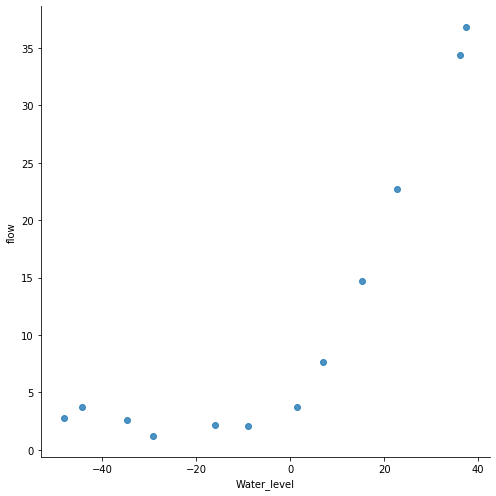

In [6]:
sns.lmplot('Water_level', 'flow', data=data, fit_reg=False, height=7)
plt.show()

In [7]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[1]), axis=1) for x in (X, Xval, Xtest)]
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

# Cost function

<img style="float: left;" src="../img/linear_cost.png">

## Regularized cost
![linear_reg_cost](../img/linear_reg_cost.png)

In [63]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n, 1), linear regression parameters
    """
    m = X.shape[0]
    temp = X@theta - y
    return (temp.T @ temp) / (2*m)

In [116]:
def regularized_cost(theta, X, y, lambda_=1):
    m = X.shape[0]
    theta = theta.reshape((X.shape[1], 1))
    temp = theta[1:,:]
    regularized_term = (lambda_ / (2 * m)) * (temp.T @ temp)
    return cost(theta, X, y) + regularized_term

In [117]:
theta = np.ones((X.shape[1], 1))

In [118]:
cost(theta, X, y)

array([[303.95152555]])

In [119]:
regularized_cost(theta, X, y)

array([[303.99319222]])

# Gradient

<img style="float: left;" src="../img/linear_gradient.png">

## Regularized gradient

<img style="float: left;" src="../img/linear_reg_gradient.png">

In [110]:
def gradient(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n, 1), linear regression parameters
    """
    m = X.shape[0]
    inner = X.T @(X @ theta - y)  # n, 1
    return inner / m 

In [111]:
gradient(theta, X, y)

array([[-15.30301567],
       [598.16741084]])

In [124]:
def regularized_gradient(theta, X, y, lambda_=1):
    m = X.shape[0]
    theta = theta.reshape((X.shape[1], 1))
    temp = theta.copy()
    temp[0,:] = 0
    regularized_term = (lambda_ / m) * temp
    return gradient(theta, X, y) + regularized_term

In [125]:
regularized_gradient(theta, X, y)

array([[-15.30301567],
       [598.25074417]])

# Training

In [126]:
def linear_regression_np(X, y, lambda_=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, 1)
        lambda_: lambda constant for regularization

    return: trained parameters
    """
    theta_ = np.ones((X.shape[1], 1))
    
    res = opt.minimize(fun=regularized_cost,
                      x0=theta_,
                      args=(X, y, lambda_),
                      method='TNC',
                      jac=regularized_gradient,
                      options={'disp': True})
    return res

In [127]:
res = linear_regression_np(X, y, lambda_=0)

In [128]:
res.x

array([13.08790398,  0.36777923])

In [132]:
k, b = res.x[1], res.x[0]

## Underfitting

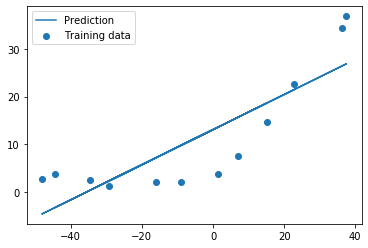

In [133]:
plt.scatter(X[:, 1], y, label='Training data')
plt.plot(X[:, 1], X[:, 1]*k + b, label='Prediction')
plt.legend(loc=2)
plt.show()

In [137]:
m = X.shape[0]
training_cost, cv_cost = [], []
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], lambda_=0)
    tc = regularized_cost(res.x, X[:i, :], y[:i], lambda_=0)
    cv = regularized_cost(res.x, Xval, yval, lambda_=0)    
    
    training_cost.append(tc)
    cv_cost.append(cv)

In [143]:
training_cost = np.squeeze(np.array(training_cost))
cv_cost = np.squeeze(np.array(cv_cost))

In [144]:
training_cost.shape, cv_cost.shape

((12,), (12,))

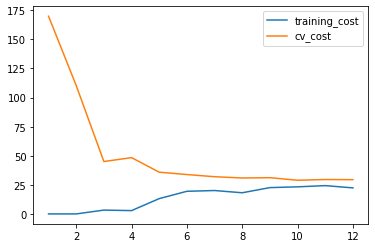

In [145]:
plt.plot(np.arange(1, m+1), training_cost, label='training_cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv_cost')
plt.legend(loc=1)
plt.show()

# Add features

In [167]:
X, y, Xtest, ytest, Xval, yval = df['X'], df['y'], df['Xtest'], df['ytest'], df['Xval'], df['yval']

## Features processing

In [181]:
def poly_features(x, power, as_ndarray=False):
    x = np.ravel(x)
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power+1)}
    df = pd.DataFrame(data)
    
    return df.values if as_ndarray else df

In [182]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [183]:
poly_features(X, power=8)

,f1,f2,f3,f4,f5,f6,f7,f8
0,-15.936758,253.980260,-4047.621971,6.450597e+04,-1.028016e+06,1.638324e+07,-2.610958e+08,4.161020e+09
1,-29.152979,849.896197,-24777.006175,7.223235e+05,-2.105788e+07,6.139000e+08,-1.789701e+10,5.217513e+11
2,36.189549,1309.683430,47396.852168,1.715271e+06,6.207487e+07,2.246462e+09,8.129843e+10,2.942154e+12
3,37.492187,1405.664111,52701.422173,1.975892e+06,7.408050e+07,2.777440e+09,1.041323e+11,3.904148e+12
4,-48.058829,2309.651088,-110999.127750,5.334488e+06,-2.563693e+08,1.232081e+10,-5.921235e+11,2.845676e+13
5,-8.941458,79.949670,-714.866612,6.391950e+03,-5.715335e+04,5.110343e+05,-4.569391e+06,4.085702e+07
6,15.307793,234.328523,3587.052500,5.490986e+04,8.405487e+05,1.286695e+07,1.969645e+08,3.015092e+09
7,-34.706266,1204.524887,-41804.560890,1.450880e+06,-5.035463e+07,1.747621e+09,-6.065341e+10,2.105053e+12
8,1.389154,1.929750,2.680720,3.723935e+00,5.173120e+00,7.186262e+00,9.982827e+00,1.386769e+01
9,-44.383760,1969.918139,-87432.373590,3.880577e+06,-1.722346e+08,7.644420e+09,-3.392881e+11,1.505888e+13


In [184]:
# apply to X, Xval, Xtest
def add_features(*args, power):
    def process(x):
        df = poly_features(x, power=power)
        ndarr = normalize_feature(df).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    return [process(x) for x in args]

In [185]:
X_poly, Xval_poly, Xtest_poly = add_features(X, Xval, Xtest, power=8)
X_poly.shape

(12, 9)

## Compare and selection

In [198]:
def plot_learning_curve(X, y, Xval, yval, lambda_=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    
    for i in range(1, m+1):
        res = linear_regression_np(X[:i, :], y[:i], lambda_=lambda_)
        tc = regularized_cost(res.x, X[:i, :], y[:i], lambda_=lambda_)
        cv = regularized_cost(res.x, Xval, yval, lambda_=lambda_)    
    
        training_cost.append(np.squeeze(tc))
        cv_cost.append(np.squeeze(cv))
    
    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

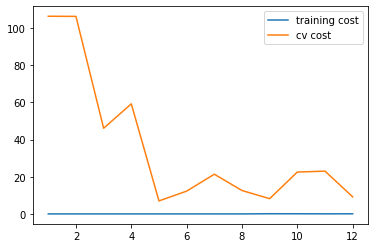

In [195]:
plot_learning_curve(X_poly, y, Xval_poly, yval)
plt.show()

> Overfitting

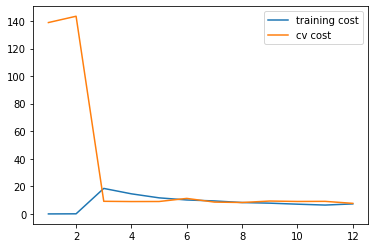

In [199]:
plot_learning_curve(X_poly, y, Xval_poly, yval, 1)
plt.show()

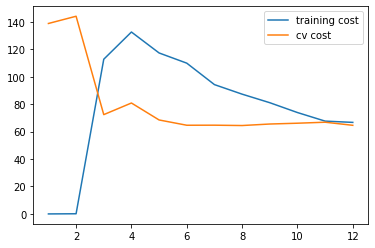

In [200]:
plot_learning_curve(X_poly, y, Xval_poly, yval, 100)
plt.show()

In [217]:
lambda_candidates = [0, .001, .003, .01, .03, .1, .3, 1, 3, 10]
training_cost, cv_cost = [], []

In [218]:
for lambda_ in lambda_candidates:
    res = linear_regression_np(X_poly, y, lambda_)
    
    tc = regularized_cost(res.x, X_poly, y)
    cv = regularized_cost(res.x, Xval_poly, yval)
    
    training_cost.append(np.ravel(tc))
    cv_cost.append(np.ravel(cv))

In [219]:
training_cost

[array([188.54055237]),
 array([63.93393989]),
 array([26.51849405]),
 array([16.5779566]),
 array([13.19603015]),
 array([10.30084099]),
 array([8.18786033]),
 array([7.2681481]),
 array([8.55679144]),
 array([17.8202158])]

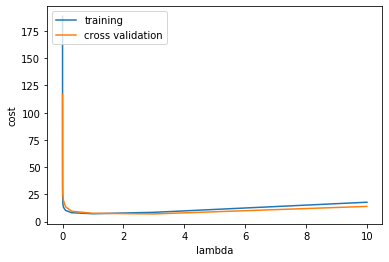

In [220]:
plt.plot(lambda_candidates, training_cost, label='training')
plt.plot(lambda_candidates, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

In [222]:
lambda_candidates[np.argmin(cv_cost)]

3

In [225]:
# use test data to compute the cost
for l in lambda_candidates:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, regularized_cost(theta, Xtest_poly, ytest)))

test cost(l=0) = [[117.86377745]]
test cost(l=0.001) = [[47.3086914]]
test cost(l=0.003) = [[26.31986791]]
test cost(l=0.01) = [[20.22705766]]
test cost(l=0.03) = [[17.40196045]]
test cost(l=0.1) = [[14.25579166]]
test cost(l=0.3) = [[11.48860053]]
test cost(l=1) = [[10.43311769]]
test cost(l=3) = [[13.73275702]]
test cost(l=10) = [[28.70250795]]


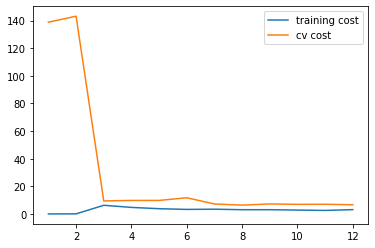

In [227]:
plot_learning_curve(X_poly, y, Xval_poly, yval, .3)
plt.show()